<a href="https://colab.research.google.com/github/VitalyGladyshev/Python_for_DS/blob/master/dl_exam_gladyshevvv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models import densenet121, DenseNet121_Weights

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
!nvidia-smi

Sun Jun 15 14:41:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Загрузка данных и разведочный анализ

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 20
LEARNING_RATE_STAGE1 = 0.001
LEARNING_RATE_STAGE2 = 0.0001

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [ ]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [ ]:
train.shape, test.shape, val.shape

((5216, 2), (624, 2), (16, 2))

## Подготовка данных

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

### Конвертация и нормализация

In [ ]:
x_train = np.array(x_train, dtype='float32') / 255.0
y_train = np.array(y_train, dtype='int64')
x_val = np.array(x_val, dtype='float32') / 255.0
y_val = np.array(y_val, dtype='int64')
x_test = np.array(x_test, dtype='float32') / 255.0
y_test = np.array(y_test, dtype='int64')

In [ ]:
x_train = torch.tensor(x_train).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(y_train)
x_val = torch.tensor(x_val).unsqueeze(1)
y_val = torch.tensor(y_val)
x_test = torch.tensor(x_test).unsqueeze(1)
y_test = torch.tensor(y_test)

In [ ]:
print(f"Выборка для обучения: {len(x_train)}")
print(f"Выборка для валидации: {len(x_val)}")
print(f"Тестовая выборка: {len(x_test)}")

Выборка для обучения: 5216
Выборка для валидации: 16
Тестовая выборка: 624


## Баланс классов

In [ ]:
train_class_counts = np.bincount(y_train)
print(f"\nБаланс классов:")
print(f"NORMAL: {train_class_counts[1]}, PNEUMONIA: {train_class_counts[0]}")


Баланс классов:
NORMAL: 1341, PNEUMONIA: 3875


### Веса классов для борьбы с дисбалансом

In [ ]:
class_weights = torch.tensor([
    len(y_train) / (2 * train_class_counts[0]),
    len(y_train) / (2 * train_class_counts[1])
], dtype=torch.float32).to(DEVICE)

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("PNEUMONIA")
    else:
        l.append("NORMAL")

dt = pd.DataFrame(l)
cases_count = dt.value_counts()
print(cases_count)

0        
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64


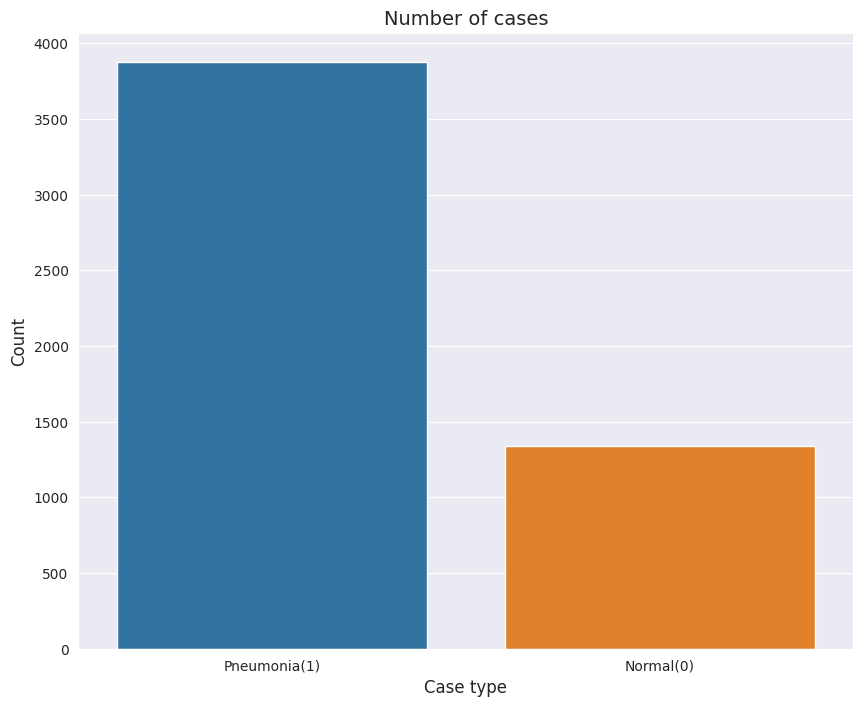

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index.values, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index.values)), ['Pneumonia(1)', 'Normal(0)'])
plt.show()

## Формируем датасеты для Pytorch

### Аугментации

In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

valid_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
class XRayDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)
            # Дублируем канал для создания 3-канального изображения для DenseNet
            img = img.repeat(3, 1, 1)

        return img, label

In [ ]:
train_dataset = XRayDataset(x_train, y_train, transform=train_transform)
valid_dataset = XRayDataset(x_val, y_val, transform=valid_transform)
test_dataset = XRayDataset(x_test, y_test, transform=valid_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True)

In [ ]:
len(valid_dataset)

16

Метка: 0


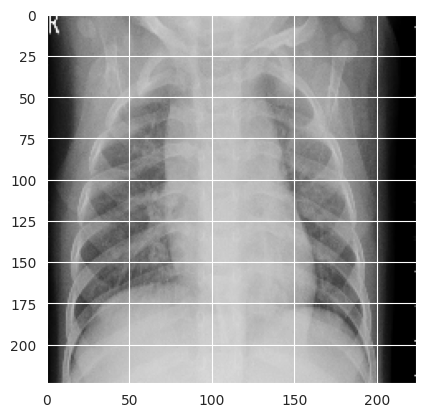

Метка: 0


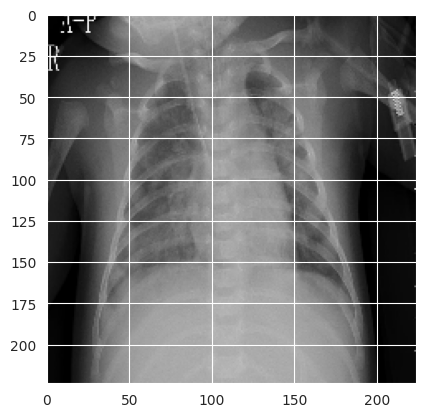

Метка: 0


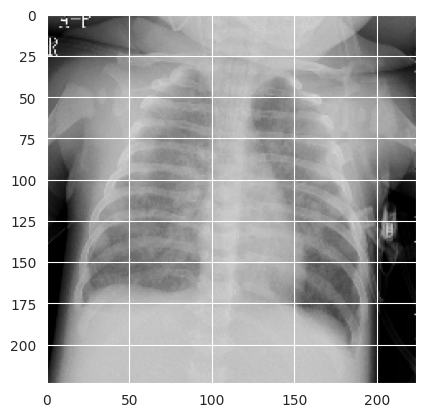

Метка: 0


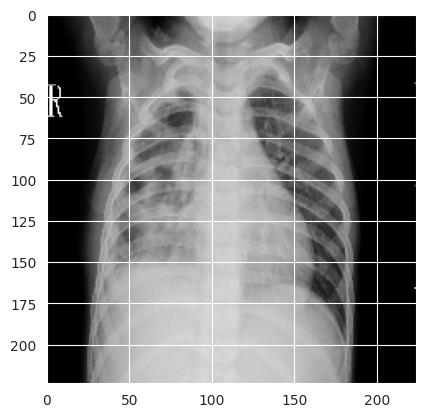

Метка: 0


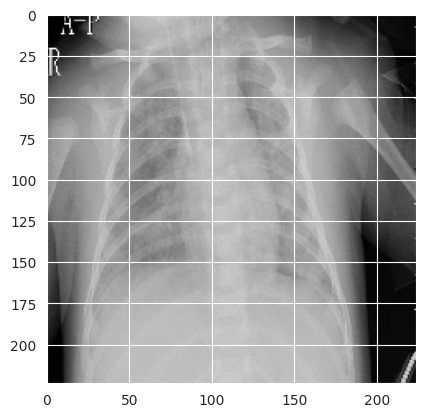

Метка: 0


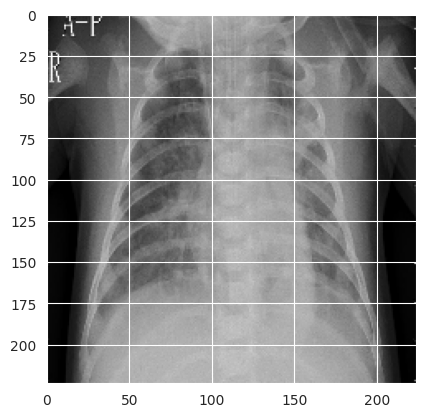

In [ ]:
data_iter = iter(valid_dataset)

for i in range(6):
    images_c, labels_c = next(data_iter)
    print(f'Метка: {labels_c}')
    img = torchvision.utils.make_grid(images_c)
    image_np = img.permute(1, 2, 0).numpy()
    plt.imshow(image_np[:, :, 0], cmap='gray')
    plt.show()

# Создание и обучение модели на базе DenseNet121

## Модель DenseNet121 для бинарной классификации

In [ ]:
class DenseNet121Binary(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(DenseNet121Binary, self).__init__()

        # Загружаем предобученную модель
        self.backbone = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

        in_features = self.backbone.classifier.in_features

        # Заменяем классификатор
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate/2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate/2),

            nn.Linear(128, 2)  # 2 класса
        )

        # Замораживаем backbone
        self._freeze_backbone()

        # Инициализация весов классификатора
        self._initialize_classifier()

    def _freeze_backbone(self):
        """Замораживает feature extractor"""
        for param in self.backbone.features.parameters():
            param.requires_grad = False

    def _unfreeze_backbone(self):
        """Размораживает feature extractor для fine-tuning"""
        for param in self.backbone.features.parameters():
            param.requires_grad = True

    def _initialize_classifier(self):
        """Инициализация весов классификатора"""
        for module in self.backbone.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm1d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        return self.backbone(x)

    def unfreeze_for_finetuning(self):
        """Размораживает всю модель для fine-tuning"""
        self._unfreeze_backbone()

### Функции для обучения и валидации

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': loss.item(), 'acc': 100.*correct/total})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [ ]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Сохраняем предсказания для метрик
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())  # Вероятность класса PNEUMONIA
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({'loss': loss.item(), 'acc': 100.*correct/total})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

## Двухстадийное обучение

In [ ]:
model = DenseNet121Binary(dropout_rate=0.3)
model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 179MB/s]


In [ ]:
print(f"Модель загружена на {DEVICE}")
print(f"Всего параметров: {sum(p.numel() for p in model.parameters()):,}")
print(f"Обучаемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Модель загружена на cuda
Всего параметров: 7,644,930
Обучаемых параметров: 691,074


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

### СТАДИЯ 1: Обучение только классификатора

In [ ]:
print("СТАДИЯ 1: Обучение только классификатора")

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE_STAGE1
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, verbose=True
)

best_valid_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(EPOCHS_STAGE1):
    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE1}")

    # Обучение
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

    # Валидация
    valid_loss, valid_acc, _, _, _ = validate_epoch(model, valid_loader, criterion, DEVICE)

    # Сохранение метрик
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%")

    # Learning rate scheduling
    scheduler.step(valid_loss)

    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        # Сохраняем лучшую модель
        torch.save(model.state_dict(), 'best_model_stage1.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Загружаем лучшую модель стадии 1
model.load_state_dict(torch.load('best_model_stage1.pth'))

СТАДИЯ 1: Обучение только классификатора

Epoch 1/10


Validation: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s, loss=4.37, acc=68.8]


Train Loss: 2.0720, Train Acc: 74.46%
Valid Loss: 4.3673, Valid Acc: 68.75%

Epoch 2/10


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s, loss=0.58, acc=87.5]


Train Loss: 1.0245, Train Acc: 85.76%
Valid Loss: 0.5803, Valid Acc: 87.50%

Epoch 3/10


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s, loss=0.773, acc=87.5]


Train Loss: 0.9094, Train Acc: 86.60%
Valid Loss: 0.7728, Valid Acc: 87.50%

Epoch 4/10


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s, loss=0.771, acc=87.5]


Train Loss: 0.7361, Train Acc: 87.25%
Valid Loss: 0.7707, Valid Acc: 87.50%

Epoch 5/10


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s, loss=1.21, acc=75]


Train Loss: 0.6918, Train Acc: 87.42%
Valid Loss: 1.2126, Valid Acc: 75.00%

Epoch 6/10


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s, loss=0.66, acc=75]


Train Loss: 0.6039, Train Acc: 87.86%
Valid Loss: 0.6600, Valid Acc: 75.00%

Epoch 7/10


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s, loss=0.411, acc=81.2]


Train Loss: 0.4965, Train Acc: 88.92%
Valid Loss: 0.4107, Valid Acc: 81.25%

Epoch 8/10


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s, loss=0.314, acc=87.5]


Train Loss: 0.4719, Train Acc: 88.57%
Valid Loss: 0.3138, Valid Acc: 87.50%

Epoch 9/10


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s, loss=0.396, acc=87.5]


Train Loss: 0.4120, Train Acc: 89.84%
Valid Loss: 0.3959, Valid Acc: 87.50%

Epoch 10/10


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s, loss=0.256, acc=87.5]


Train Loss: 0.4235, Train Acc: 89.59%
Valid Loss: 0.2559, Valid Acc: 87.50%


<All keys matched successfully>

### СТАДИЯ 2: Fine-tuning всей модели

In [ ]:
print("СТАДИЯ 2: Fine-tuning всей модели")

# Размораживаем всю модель
model.unfreeze_for_finetuning()

# Используем разные learning rates для разных частей модели
optimizer = torch.optim.Adam([
    {'params': model.backbone.features.parameters(), 'lr': LEARNING_RATE_STAGE2},
    {'params': model.backbone.classifier.parameters(), 'lr': LEARNING_RATE_STAGE2 * 10}
])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_STAGE2)

best_valid_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS_STAGE2):
    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE2}")

    # Обучение
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

    # Валидация
    valid_loss, valid_acc, _, _, _ = validate_epoch(model, valid_loader, criterion, DEVICE)

    # Сохранение метрик
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%")

    # Learning rate scheduling
    scheduler.step()

    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        patience_counter = 0
        # Сохраняем лучшую модель
        torch.save(model.state_dict(), 'best_model_stage2.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Загружаем лучшую модель
model.load_state_dict(torch.load('best_model_stage2.pth'))

СТАДИЯ 2: Fine-tuning всей модели

Epoch 1/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s, loss=0.301, acc=93.8]


Train Loss: 0.2740, Train Acc: 91.72%
Valid Loss: 0.3013, Valid Acc: 93.75%

Epoch 2/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s, loss=0.385, acc=87.5]


Train Loss: 0.1507, Train Acc: 94.98%
Valid Loss: 0.3852, Valid Acc: 87.50%

Epoch 3/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s, loss=0.341, acc=87.5]


Train Loss: 0.1055, Train Acc: 96.89%
Valid Loss: 0.3412, Valid Acc: 87.50%

Epoch 4/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s, loss=0.178, acc=100]


Train Loss: 0.0851, Train Acc: 97.05%
Valid Loss: 0.1778, Valid Acc: 100.00%

Epoch 5/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s, loss=0.329, acc=93.8]


Train Loss: 0.0581, Train Acc: 98.20%
Valid Loss: 0.3290, Valid Acc: 93.75%

Epoch 6/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s, loss=0.0994, acc=100]


Train Loss: 0.0593, Train Acc: 97.91%
Valid Loss: 0.0994, Valid Acc: 100.00%

Epoch 7/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s, loss=0.0983, acc=93.8]


Train Loss: 0.0618, Train Acc: 98.04%
Valid Loss: 0.0983, Valid Acc: 93.75%

Epoch 8/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s, loss=0.206, acc=93.8]


Train Loss: 0.0520, Train Acc: 98.22%
Valid Loss: 0.2065, Valid Acc: 93.75%

Epoch 9/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s, loss=0.148, acc=100]


Train Loss: 0.0417, Train Acc: 98.43%
Valid Loss: 0.1481, Valid Acc: 100.00%

Epoch 10/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s, loss=0.129, acc=100]


Train Loss: 0.0294, Train Acc: 98.77%
Valid Loss: 0.1285, Valid Acc: 100.00%

Epoch 11/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.73it/s, loss=0.0725, acc=100]


Train Loss: 0.0242, Train Acc: 99.25%
Valid Loss: 0.0725, Valid Acc: 100.00%

Epoch 12/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s, loss=0.218, acc=100]


Train Loss: 0.0319, Train Acc: 98.83%
Valid Loss: 0.2178, Valid Acc: 100.00%

Epoch 13/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.86it/s, loss=0.0847, acc=100]


Train Loss: 0.0225, Train Acc: 99.31%
Valid Loss: 0.0847, Valid Acc: 100.00%

Epoch 14/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s, loss=0.27, acc=87.5]


Train Loss: 0.0209, Train Acc: 99.33%
Valid Loss: 0.2703, Valid Acc: 87.50%

Epoch 15/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s, loss=0.0453, acc=100]


Train Loss: 0.0140, Train Acc: 99.54%
Valid Loss: 0.0453, Valid Acc: 100.00%

Epoch 16/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.94it/s, loss=0.0285, acc=100]


Train Loss: 0.0176, Train Acc: 99.39%
Valid Loss: 0.0285, Valid Acc: 100.00%

Epoch 17/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s, loss=0.0619, acc=100]


Train Loss: 0.0128, Train Acc: 99.56%
Valid Loss: 0.0619, Valid Acc: 100.00%

Epoch 18/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.07it/s, loss=0.0753, acc=100]


Train Loss: 0.0121, Train Acc: 99.52%
Valid Loss: 0.0753, Valid Acc: 100.00%

Epoch 19/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  5.72it/s, loss=0.121, acc=100]


Train Loss: 0.0096, Train Acc: 99.58%
Valid Loss: 0.1212, Valid Acc: 100.00%

Epoch 20/20


Validation: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s, loss=0.0765, acc=100]


Train Loss: 0.0074, Train Acc: 99.71%
Valid Loss: 0.0765, Valid Acc: 100.00%


<All keys matched successfully>

## Визуализация профиля обучения

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


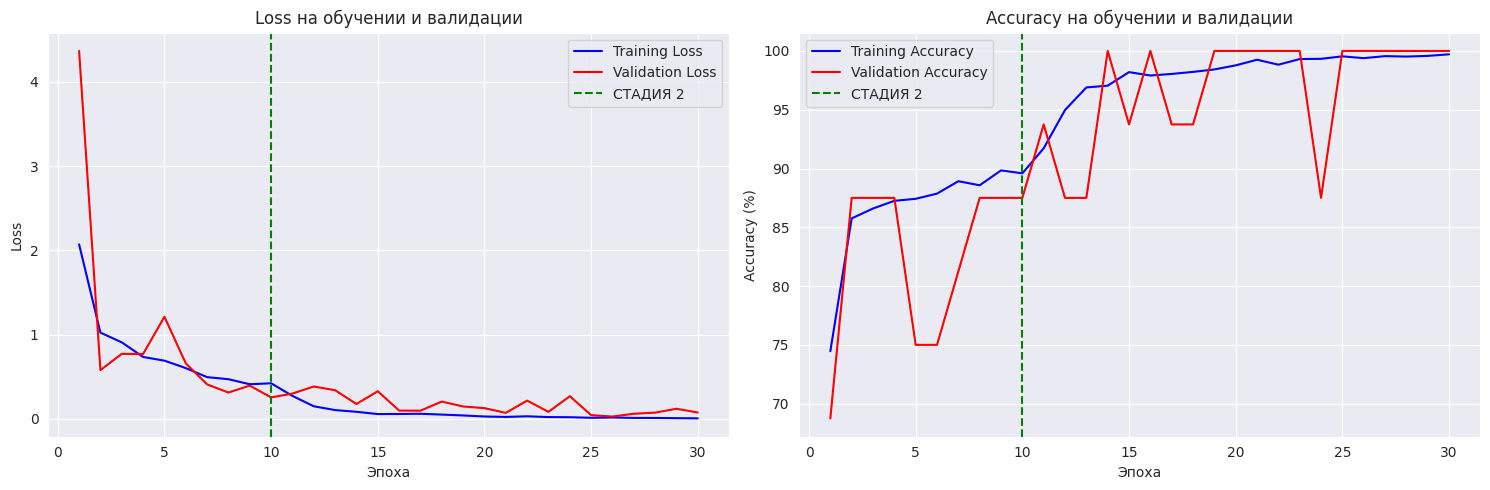

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(train_losses) + 1)

# Loss plot
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, valid_losses, 'r-', label='Validation Loss')
ax1.axvline(x=EPOCHS_STAGE1, color='g', linestyle='--', label='СТАДИЯ 2')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Loss')
ax1.set_title('Loss на обучении и валидации')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
ax2.plot(epochs, valid_accs, 'r-', label='Validation Accuracy')
ax2.axvline(x=EPOCHS_STAGE1, color='g', linestyle='--', label='СТАДИЯ 2')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy на обучении и валидации')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Оценка модели

Validation: 100%|██████████| 20/20 [00:01<00:00, 15.40it/s, loss=1.52, acc=91.2]   



TEST RESULTS
Test Loss: 0.4070
Test Accuracy: 91.19%

Classification Report:
              precision    recall  f1-score   support

   PNEUMONIA       0.88      0.99      0.93       390
      NORMAL       0.98      0.78      0.87       234

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624


ROC-AUC Score: 0.9841


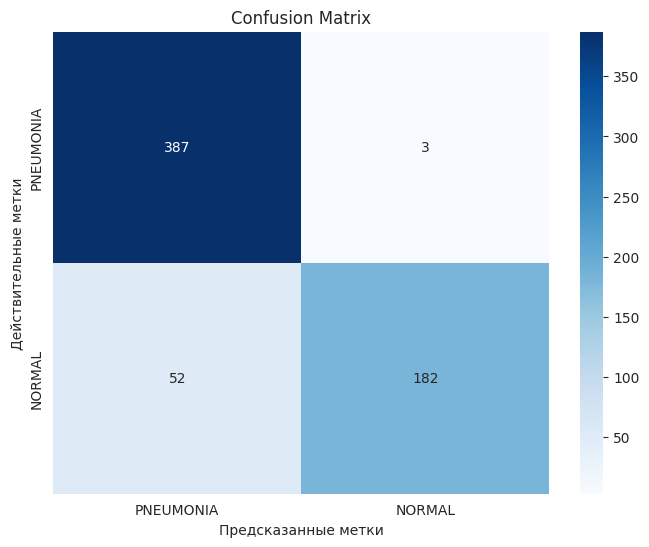

In [ ]:
model.eval()
criterion = nn.CrossEntropyLoss()

test_loss, test_acc, all_preds, all_labels, all_probs = validate_epoch(
    model, test_loader, criterion, DEVICE
)

print("\n" + "="*50)
print("TEST RESULTS")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))

# ROC-AUC Score
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Действительные метки')
plt.xlabel('Предсказанные метки')
plt.show()

## Сохранение результата

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'roc_auc': roc_auc
}, 'final_densenet121_xray_model.pth')